
# TASK: Data Loader + CSRNet Model + Training Functions
 Includes:
 CrowdDataset, generate_density_map
 CSRNet architecture
 train_and_save(model already trained and weights are saved)

Device: cuda


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Found existing model at /content/drive/MyDrive/ShanghaiTech/best_csrnet.pth. Loading it instead of training.
Model ready. Now evaluating / predicting.


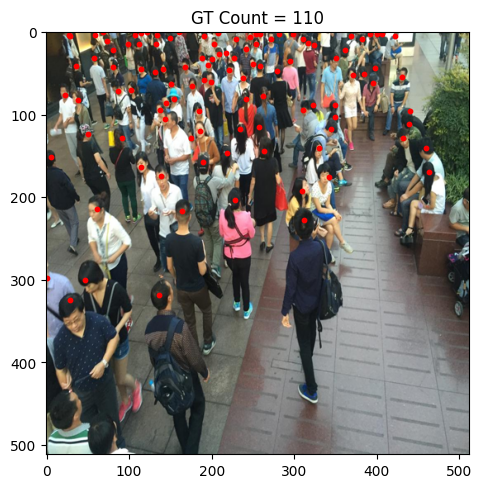

In [9]:

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
from tqdm import tqdm
import scipy.io as sio


transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


class CSRNet(nn.Module):
    def __init__(self, load_weights=True):
        super(CSRNet, self).__init__()
        vgg = models.vgg16_bn(pretrained=load_weights)
        self.frontend = nn.Sequential(*list(vgg.features.children())[:33])
        self.backend = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 256, kernel_size=3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, kernel_size=3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, kernel_size=3, padding=2, dilation=2),
            nn.ReLU(inplace=True)
        )
        self.output_layer = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output_layer(x)
        return x



class CrowdDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_dir = os.path.join(root_dir, "images")
        self.gt_dir = os.path.join(root_dir, "ground-truth")
        self.image_paths = [
            os.path.join(self.image_dir, img)
            for img in os.listdir(self.image_dir)
            if img.lower().endswith(".jpg")
        ]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        original_img = Image.open(img_path).convert("RGB")
        original_size = original_img.size


        filename = os.path.basename(img_path).replace(".jpg", ".mat")
        gt_filename = "GT_" + filename
        gt_path = os.path.join(self.gt_dir, gt_filename)
        if not os.path.exists(gt_path):
            raise FileNotFoundError(f"Ground truth {gt_path} missing")

        mat = sio.loadmat(gt_path)
        points = mat["image_info"][0, 0][0, 0][0]  # Nx2 array

        # transform image
        if self.transform:
            image = self.transform(original_img)
        else:
            image = transforms.ToTensor()(original_img)


        ow, oh = original_size
        sx = 512.0 / ow
        sy = 512.0 / oh
        scaled_points = [[p[0] * sx, p[1] * sy] for p in points]

        density_map = generate_density_map(scaled_points, (512, 512), sigma=15)
        density_map = torch.from_numpy(density_map).float()

        count = len(points)

        return image, density_map, count, img_path



def generate_density_map(points, image_shape, sigma=15):
    h, w = image_shape
    density = np.zeros((h, w), dtype=np.float32)
    if len(points) == 0:
        return density
    for p in points:
        x, y = int(p[0]), int(p[1])
        if 0 <= x < w and 0 <= y < h:
            # gaussian kernel
            kernel_size = int(6 * sigma + 1)
            if kernel_size % 2 == 0:
                kernel_size += 1
            xx, yy = np.meshgrid(np.arange(kernel_size), np.arange(kernel_size))
            center = kernel_size // 2
            gaussian = np.exp(-((xx - center) ** 2 + (yy - center) ** 2) / (2 * sigma ** 2))
            gaussian = gaussian / (2 * np.pi * sigma ** 2)

            x_min = max(0, x - center)
            x_max = min(w, x + center + 1)
            y_min = max(0, y - center)
            y_max = min(h, y + center + 1)

            kx_min = max(0, center - x)
            kx_max = kx_min + (x_max - x_min)
            ky_min = max(0, center - y)
            ky_max = ky_min + (y_max - y_min)

            density[y_min:y_max, x_min:x_max] += gaussian[ky_min:ky_max, kx_min:kx_max]
    return density



def custom_collate(batch):
    images, dens, counts, paths = zip(*batch)
    images = torch.stack(images, 0)
    dens = torch.stack(dens, 0)
    return images, dens, list(counts), list(paths)



def train_and_save(model, train_loader, val_loader, device,
                   num_epochs=50, lr=1e-5,
                   model_save_path="best_csrnet.pth"):
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

    best_val_mae = float('inf')


    if os.path.exists(model_save_path):
        print(f"Found existing model at {model_save_path}. Loading it instead of training.")
        checkpoint = torch.load(model_save_path, map_location=device, weights_only=False)
        model.load_state_dict(checkpoint['model_state_dict'])
        return model

    print(f"Training for {num_epochs} epochs...")
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        cnt = 0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
        for images, dens_maps, counts, paths in pbar:
            images = images.to(device)
            dens_maps = dens_maps.to(device)

            optimizer.zero_grad()
            outputs = model(images)

            if outputs.size() != dens_maps.unsqueeze(1).size():
                outputs = F.interpolate(outputs, size=dens_maps.shape[1:], mode='bilinear', align_corners=False)
            loss = criterion(outputs, dens_maps.unsqueeze(1))
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            cnt += 1
            pbar.set_postfix({"loss": running_loss / cnt})

        scheduler.step()

        # validation
        model.eval()
        val_loss = 0.0
        val_mae = 0.0
        vcnt = 0
        with torch.no_grad():
            for images, dens_maps, counts, paths in tqdm(val_loader, desc="Validation"):
                images = images.to(device)
                dens_maps = dens_maps.to(device)
                outputs = model(images)
                if outputs.size() != dens_maps.unsqueeze(1).size():
                    outputs = F.interpolate(outputs,
                                            size=dens_maps.shape[1:],
                                            mode='bilinear',
                                            align_corners=False)
                loss = criterion(outputs, dens_maps.unsqueeze(1))
                val_loss += loss.item()

                # count error
                pred_counts = outputs.sum(dim=(1, 2, 3)).cpu().numpy()
                gt_counts = np.array(counts)
                val_mae += np.mean(np.abs(pred_counts - gt_counts))
                vcnt += 1

        avg_val_loss = val_loss / vcnt
        avg_val_mae = val_mae / vcnt
        print(f"\nEpoch {epoch+1} VAL loss {avg_val_loss:.6f}, MAE {avg_val_mae:.2f}")

        # Save best
        if avg_val_mae < best_val_mae:
            best_val_mae = avg_val_mae
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'val_mae': avg_val_mae,
                'val_loss': avg_val_loss,
            }, model_save_path)
            print(f" — New best model saved at epoch {epoch+1}, MAE {avg_val_mae:.2f}")

    return model



def predict_on_image(model, img_path, device, transform, gt_mat_path=None):
    model.eval()
    with torch.no_grad():
        # load image
        img = Image.open(img_path).convert("RGB")
        orig_size = img.size
        img_t = transform(img).unsqueeze(0).to(device)

        # forward
        '''output = model(img_t)
        output = F.interpolate(output, size=(512, 512), mode='bilinear', align_corners=False)
        density_map = output[0, 0].cpu().numpy()


        pred_count = float(density_map.sum())
'''

        gt_count = None
        points = None
        if gt_mat_path is not None and os.path.exists(gt_mat_path):
            mat = sio.loadmat(gt_mat_path)
            points = mat["image_info"][0, 0][0, 0][0]
            gt_count = len(points)



        img_np = np.array(img.resize((512, 512)))
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(img_np)
        if points is not None:

            sx = 512 / orig_size[0]
            sy = 512 / orig_size[1]
            for p in points:
                x = int(p[0] * sx)
                y = int(p[1] * sy)
                plt.scatter(x, y, c='red', s=10)
        plt.title(f"GT Count = {gt_count}" if gt_count is not None else "Image")

        #plt.subplot(1, 2, 2)

        #dm_vis = density_map / (density_map.max() + 1e-6)
        #plt.imshow(dm_vis, cmap='hot')
        #plt.title(f"Predicted = {pred_count:.2f}")
        #plt.colorbar()


        plt.show()

        return pred_count, gt_count, density_map, points



if __name__ == "__main__":

    train_dir = "/content/drive/MyDrive/ShanghaiTech/part_B/train_data"
    test_dir = "/content/drive/MyDrive/ShanghaiTech/part_B/test_data"
    model_path = "/content/drive/MyDrive/ShanghaiTech/best_csrnet.pth"

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Device:", device)


    train_dataset = CrowdDataset(root_dir=train_dir, transform=transform)
    test_dataset = CrowdDataset(root_dir=test_dir, transform=transform)


    total = len(train_dataset)
    val_count = int(0.2 * total)
    train_count = total - val_count
    train_subset, val_subset = torch.utils.data.random_split(train_dataset, [train_count, val_count])

    train_loader = DataLoader(train_subset, batch_size=4, shuffle=True, collate_fn=custom_collate, num_workers=2)
    val_loader = DataLoader(val_subset, batch_size=4, shuffle=False, collate_fn=custom_collate, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=custom_collate, num_workers=2)

    # model
    model = CSRNet(load_weights=True)

    # train or load
    model = train_and_save(model, train_loader, val_loader, device,
                           num_epochs=50, lr=1e-5, model_save_path=model_path)

    print("Model ready. Now evaluating / predicting.")




    img_path = test_dataset.image_paths[0]

    mat_name = "GT_" + os.path.basename(img_path).replace(".jpg", ".mat")
    gt_mat = os.path.join(test_dir, "ground-truth", mat_name)
    pred_count, gt_count, density_map, points = predict_on_image(model, img_path, device, transform, gt_mat)

    #print(f"Predicted: {pred_count:.2f}, Ground truth: {gt_count}")




# TASK: Install Dependencies




In [10]:

!pip install torch torchvision torchaudio --quiet
!pip install matplotlib numpy pillow tqdm scipy --quiet

#  Streamlit
!pip install streamlit --quiet

#  OpenCV for video processing
!pip install opencv-python-headless --quiet

!pip install twilio --quiet
!pip install yagmail --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 98.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 140.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 385.7/385.7 kB 14.0 MB/s eta 0:00:00


In [11]:
import torch
torch.cuda.is_available()


True


# TASK: Ngrok + Streamlit Setup
 Includes:
 pyngrok auth token and
 starting ngrok for Streamlit



In [12]:

!pip install -q streamlit opencv-python-headless torch torchvision matplotlib pillow pyngrok


from pyngrok import ngrok
import time
import os

NGROK_AUTH_TOKEN = "33Neg4Jdex933PRLHO1SeBfjpeN_3EhDiGtCrw8UwzJU6DKCP"
!ngrok authtoken $NGROK_AUTH_TOKEN
ngrok.kill()



Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


# TASK: Streamlit Dashboard


In [13]:
%%writefile /content/streamlit_app.py
import streamlit as st
import cv2
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import time
from torchvision import transforms
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart

# CSRNet Model

class CSRNet(nn.Module):
    def __init__(self, load_weights=True):
        super(CSRNet, self).__init__()
        vgg = models.vgg16_bn(pretrained=load_weights)
        self.frontend = nn.Sequential(*list(vgg.features.children())[:33])
        self.backend = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 256, kernel_size=3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, kernel_size=3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, kernel_size=3, padding=2, dilation=2),
            nn.ReLU(inplace=True)
        )
        self.output_layer = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output_layer(x)
        return x

# Streamlit UI

st.set_page_config(page_title="Crowd Counting Dashboard", layout="wide")
st.title("🟢 Crowd Counting Dashboard")

threshold = st.sidebar.slider("Crowd Threshold", min_value=10, max_value=500, value=50, step=5)
frame_skip = st.sidebar.number_input("Frame Interval (process every Nth frame)", min_value=1, value=5)
video_file = st.file_uploader("Upload Video (mp4)", type=["mp4"])


# Device and Model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "/content/drive/MyDrive/ShanghaiTech/best_csrnet.pth"
model = CSRNet(load_weights=False).to(device)

checkpoint = torch.load(model_path, map_location=device, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Transform
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


# Streamlit placeholders

frame_display = st.empty()
count_display = st.empty()
alert_display = st.empty()


# Email credentials

FROM_EMAIL = "mjbhuvan97@gmail.com"
APP_PASSWORD = "fhszmaujpvziwrfv"  # no spaces
TO_EMAIL = "bhuvanmj40@gmail.com"

def send_email_alert(count):
    msg = MIMEMultipart()
    msg['From'] = FROM_EMAIL
    msg['To'] = TO_EMAIL
    msg['Subject'] = "Crowd Alert"
    msg.attach(MIMEText(f"⚠️ Overcrowding Detected! Count = {count:.2f}", 'plain'))
    try:
        server = smtplib.SMTP('smtp.gmail.com', 587)
        server.starttls()
        server.login(FROM_EMAIL, APP_PASSWORD)
        server.send_message(msg)
        server.quit()
        print("Email sent!")
    except Exception as e:
        print("Error sending email:", e)


# Video processing

if video_file is not None:
    tfile = "./temp_video.mp4"
    with open(tfile, 'wb') as f:
        f.write(video_file.read())

    cap = cv2.VideoCapture(tfile)
    frame_count = 0
    crowd_counts = []
    peak_count = 0
    email_sent = False  #  flag to send email only once

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_count += 1
        if frame_count % frame_skip != 0:
            continue

        # Convert to PIL
        img_pil = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        img_t = transform(img_pil).unsqueeze(0).to(device)

        # Predict density map
        with torch.no_grad():
            output = model(img_t)
            output = F.interpolate(output, size=(512, 512), mode='bilinear', align_corners=False)
            density_map = output[0,0].cpu().numpy()
            count = density_map.sum()

        # Update stats
        crowd_counts.append(count)
        peak_count = max(peak_count, count)
        avg_count = np.mean(crowd_counts)

        # --- Visualization ---
        fig, axes = plt.subplots(1,2, figsize=(12,5))
        axes[0].imshow(img_pil)
        axes[0].set_title("Original Frame")
        axes[0].axis('off')

        axes[1].imshow(density_map, cmap='hot')
        axes[1].set_title(f"Predicted Count = {count:.2f}")
        axes[1].axis('off')

        frame_display.pyplot(fig)
        plt.close(fig)  # <--- prevent memory leak

        count_display.metric("Current Crowd Count", f"{count:.2f}", delta=f"Peak: {peak_count:.2f} | Avg: {avg_count:.2f}")

        #  Alert
        if count >= threshold:
            alert_display.warning(f"⚠️ Overcrowding Detected! Count = {count:.2f}")
            if not email_sent:  # send only once
                send_email_alert(count)
                email_sent = True
        else:
            alert_display.success("✅ Crowd below threshold")

        time.sleep(0.1)

    cap.release()
    st.success("Video processing completed!")


Writing /content/streamlit_app.py


In [14]:

!nohup streamlit run /content/streamlit_app.py --server.port 8501 --server.headless true &

time.sleep(5)

public_url = ngrok.connect(8501)
print("Your Streamlit app is live at:", public_url)


nohup: appending output to 'nohup.out'
Your Streamlit app is live at: NgrokTunnel: "https://acutilingual-suppressive-don.ngrok-free.dev" -> "http://localhost:8501"


Email sent!
